In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import time

In [2]:
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

cars_df = pd.read_csv("data/car_evaluation.csv", names = ["buying","maint", "doors", "persons", "lug_boot","safety","class"])
cars_df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
cleanup_nums = {"class":     {"unacc": 4, "acc": 3,'good': 2,'vgood':1}
                }
cars_df.replace(cleanup_nums,inplace = True)
target = cars_df['class']

In [4]:
cars_df.drop( ['class'],axis = 1,inplace = True)
cars_df_categorical = pd.get_dummies(cars_df)
cars_df_categorical.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(cars_df_categorical, target, random_state=42)

In [6]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

1296
1296
432
432


In [7]:
target.value_counts()

4    1210
3     384
2      69
1      65
Name: class, dtype: int64

In [8]:
sc=StandardScaler()
sc.fit(X_train)
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

/Users/harshsikka/opt/anaconda3/envs/CS-7641/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/harshsikka/opt/anaconda3/envs/CS-7641/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/harshsikka/opt/anaconda3/envs/CS-7641/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [9]:
from sklearn import tree
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, random_state=42)
clf_boosted.fit(X_train, Y_train)
clf_boosted.score(X_train, Y_train)


0.8603395061728395

In [10]:
f_pred = clf_boosted.predict(X_test)
print('Misclassified samples using Boost are: %d' %(Y_test!=f_pred).sum())
print('Classification Accuracy of Boost is %.2f ' %accuracy_score(Y_test,f_pred))

Misclassified samples using Boost are: 64
Classification Accuracy of Boost is 0.85 


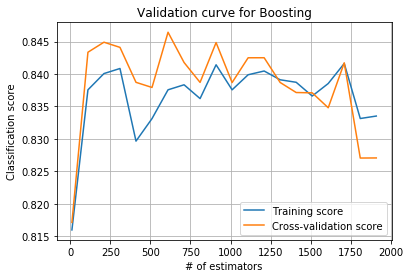

In [11]:
estimator_range = np.arange(10,2000,100)
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, random_state=42)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=1500, random_state=42)
train_scores, test_scores = validation_curve(clf_boosted, X_train, Y_train, param_name="n_estimators", param_range=estimator_range, cv=5,
                                            n_jobs=4)

plt.figure()
plt.plot(estimator_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(estimator_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for Boosting')
plt.xlabel('# of estimators')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [12]:
estimator_range = np.arange(100,300,5)
tuned_params = {'n_estimators' : estimator_range}
clf_boosted = GridSearchCV(clf_boosted, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_boosted.fit(X_train, Y_train)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])
best_clf_boosted = clf_boosted
best_boosted_params = clf_boosted.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_boosted_params)
t0 = time.time()
boosted_pred_best = clf_boosted.predict(X_test)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(Y_test, boosted_pred_best)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, boosted_pred_best))

Completed training in 17.732432 seconds
Best parameters set for decision tree found on development set:
{'n_estimators': 120}
Inference time on test data: 0.017774 seconds
Accuracy of decision tree is 83.56%
[[ 20   0   0   0]
 [  2  13   0   0]
 [  3   7  43  50]
 [  0   0   9 285]]


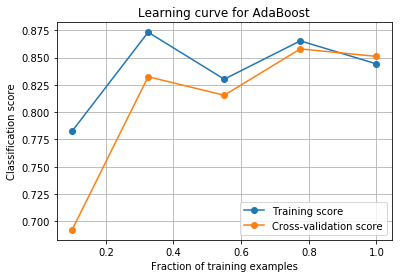

In [13]:
train_sizes = np.linspace(0.1, 1.0, 5)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=best_boosted_params['n_estimators'], random_state=42)
_, train_scores, test_scores = learning_curve(best_clf_boosted, X_train, Y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for AdaBoost')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()